In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.metrics import sensitivity_score, specificity_score

from sklearn.metrics import roc_curve, auc
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)

In [92]:
def get_dataset(fname):
    with open('names', 'r') as fcolnames:
        colnames = [name.split(':')[0] for name in fcolnames.readlines()]
    
        df = pd.read_csv(fname, names=colnames, index_col=False)
        return df

In [93]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_dict):
        self.replace_dict = replace_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return X.replace(self.replace_dict)

    def get_feature_names_out(self, names):
        return names

    def set_output(self, *, transform):
        assert transform == 'pandas'


In [94]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        if X.columns is not None:
            X = X.drop(self.columns, axis=1)
            self.feature_names = [name for name in X.columns if name not in self.columns]
            
        return X

    def get_feature_names_out(self, names):
        if names is None:
            return names
            
        return [name for name in names if name not in self.columns]


    def set_output(self, *, transform):
        assert transform == 'pandas'


In [95]:
class ZScoreOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols, factor=3):
        self.factor = factor
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('LEN' + str(len(X[(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)])))
        return X[~(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [96]:
class RangeOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, col, min, max):
        self.col = col
        self.min = min
        self.max = max
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[(X[self.col] >= self.min) & (X[self.col] <= self.max) | X[self.col].isna()]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [97]:
class ColumnBackPusher(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        col = X[self.col]
        X = X.drop(self.col, axis=1)
        return pd.concat([X, col], axis=1)
        
    def get_feature_names_out(self, names):
        return [name for name in names if name != self.col] + [self.col]
        
    def set_output(self, *, transform):
        assert transform == 'pandas'


In [145]:


class IndicatorLabelProducer():
    def __init__(self, indicator_map):
        self.indicator_map = indicator_map

    def __call__(self, given_label: str) -> str:
        if '|' in given_label:
            given_label = given_label.split('|')[1]

        
        diagset = set(given_label)
        
        for label, options in self.indicator_map.items():
            if not diagset.isdisjoint(set(options)):
                return label

        return np.NaN

class MappingLabelProducer():
    def __init__(self, mappings):
        self.mappings = mappings

    def __call__(self, given_label: str) -> str:
        if given_label in self.mappings:
            return self.mappings[given_label]

        return np.NaN
        

In [191]:
def reencode_dataset(df, label_producer):
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('[')[0])
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('.')[0])
    df['diagnosis'] = df['diagnosis'].apply(label_producer)

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except:
            pass

    return df.applymap(lambda val: np.nan if val == '?' else val)

In [192]:
indi_map = {
    'hyper' : 'ABCD',
    'hypo' : 'EFGH',
    'neg' : '-',
}

classes_map = {
    'hyperthyroid' : 'hyper',
}

df1 = get_dataset('thyroid0387.data')
df1 = reencode_dataset(df1, IndicatorLabelProducer(indi_map))

df2 = get_dataset('allhyper.data')
df2 = reencode_dataset(df2, MappingLabelProducer(classes_map))
df = pd.concat([df1, df2], ignore_index=True, axis=0)
df = df.dropna(subset=['diagnosis'])

In [193]:
df = df.drop_duplicates(keep='first')
df.diagnosis.value_counts()

neg      6763
hypo      659
hyper     290
Name: diagnosis, dtype: int64

In [194]:

bool_cols = ['on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych']

numeric_cols = ['age','TSH',
       'T3', 'TT4', 'T4U', 'FTI']

cols_to_drop = ['TSH measured',
       'T3 measured', 'TT4 measured', 'T4U measured', 
       'FTI measured', 'TBG measured', 'referral source', 'TBG', 'hypopituitary']

classes = ['hypo', 'neg', 'hyper']

def convert_to_numeric(df):
    return df.apply(pd.to_numeric, errors='coerce')

numeric_transformer = FunctionTransformer(convert_to_numeric)
label_enc = OrdinalEncoder(categories=[classes], dtype=np.int64)

prep = Pipeline(steps=[
    ('column dropper', ColumnDropper(cols_to_drop)),
    ('feature encoder', ColumnTransformer(transformers=[
        ('gender map', ValueReplacer({'M':0, 'F':1}), ['sex']),
        ('bool map', ValueReplacer({'f': 0, 't': 1}), bool_cols),
        ('label encoder',  label_enc, ['diagnosis'])
    ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")),
    ('numeric cast', numeric_transformer),
    ('zoutliers', ZScoreOutlierRemover(numeric_cols, 8)),
    ('age outliers', RangeOutlierRemover('age', 0, 100)),
    ('TSH outliers', RangeOutlierRemover('TSH', 0, 15)),
    ('label', ColumnBackPusher('diagnosis'))
]).set_output(transform='pandas')

In [195]:
df = prep.fit_transform(df)

LEN42


In [196]:
df.columns

Index(['sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI',
       'diagnosis'],
      dtype='object')

In [181]:
print(df.isna().sum(axis=0))

null_counts = df.isnull().sum(axis=1)

sex                           233
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
psych                           0
age                             0
TSH                           723
T3                           2133
TT4                           340
T4U                           651
FTI                           644
diagnosis                       0
dtype: int64


In [182]:
print(df['diagnosis'].value_counts())
print(df.dtypes)

1    6748
0     350
2     271
Name: diagnosis, dtype: int64
sex                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
psych                          int64
age                            int64
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
diagnosis                      int64
dtype: object


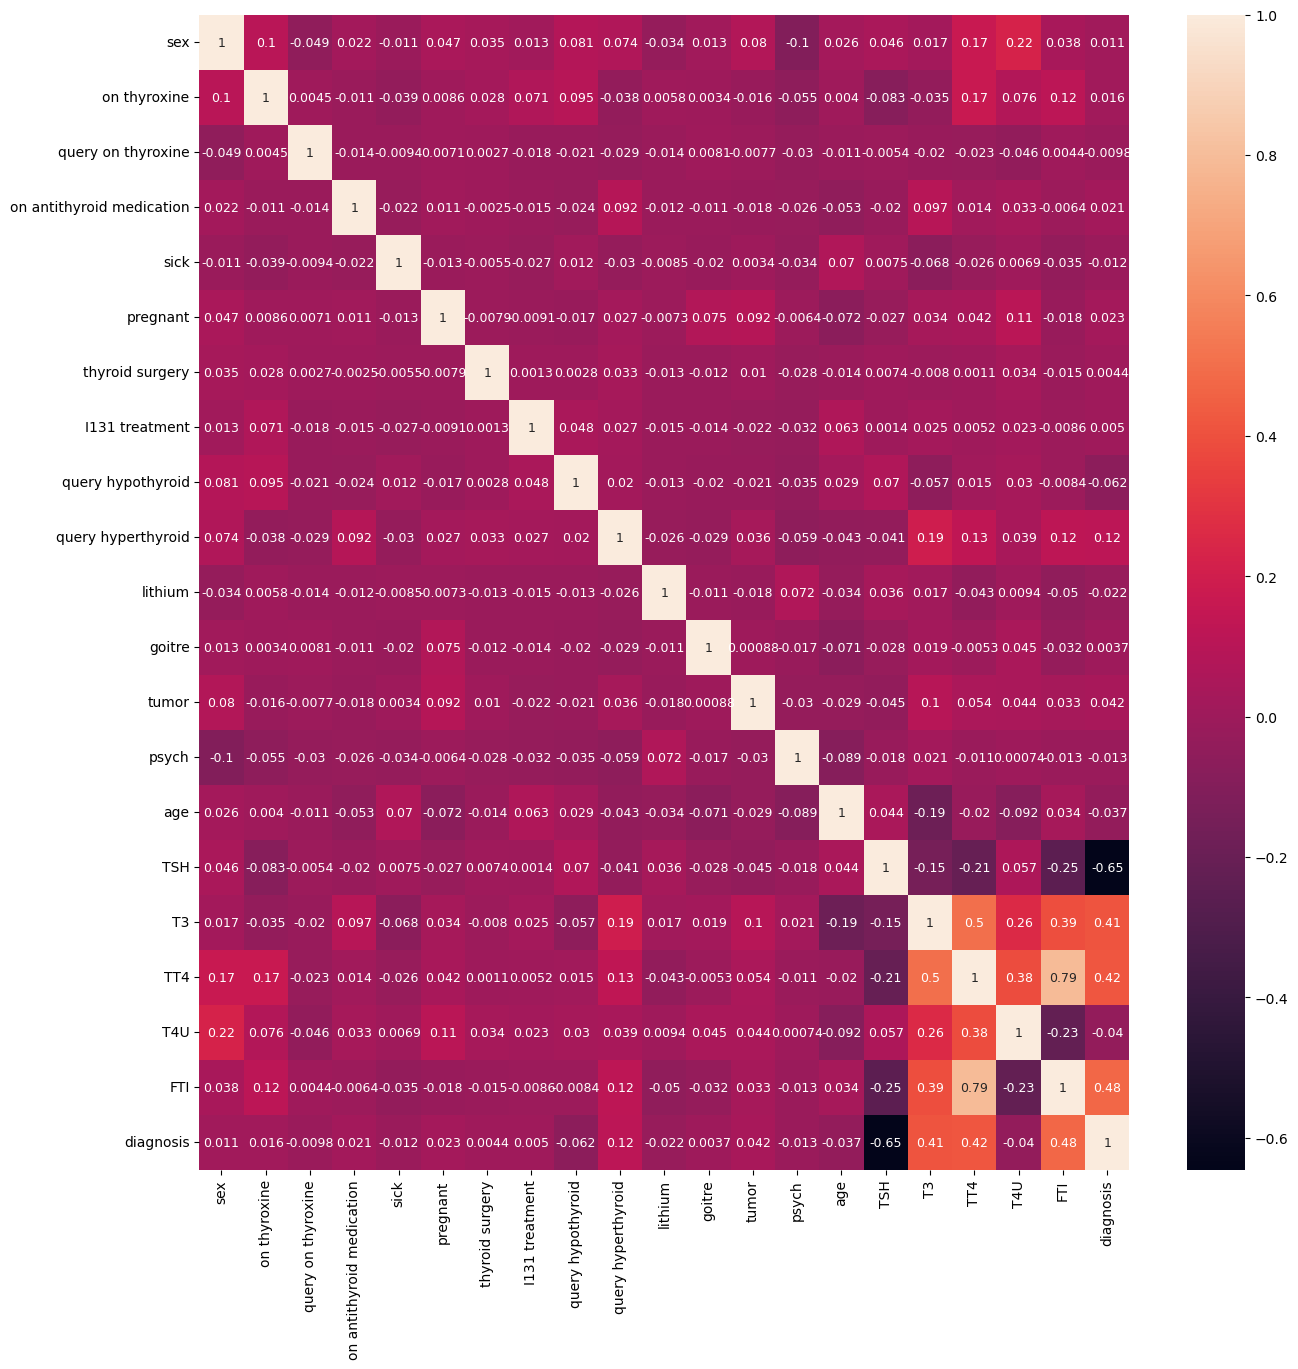

In [183]:

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, annot_kws={
    "fontsize": 9})

plt.show() 

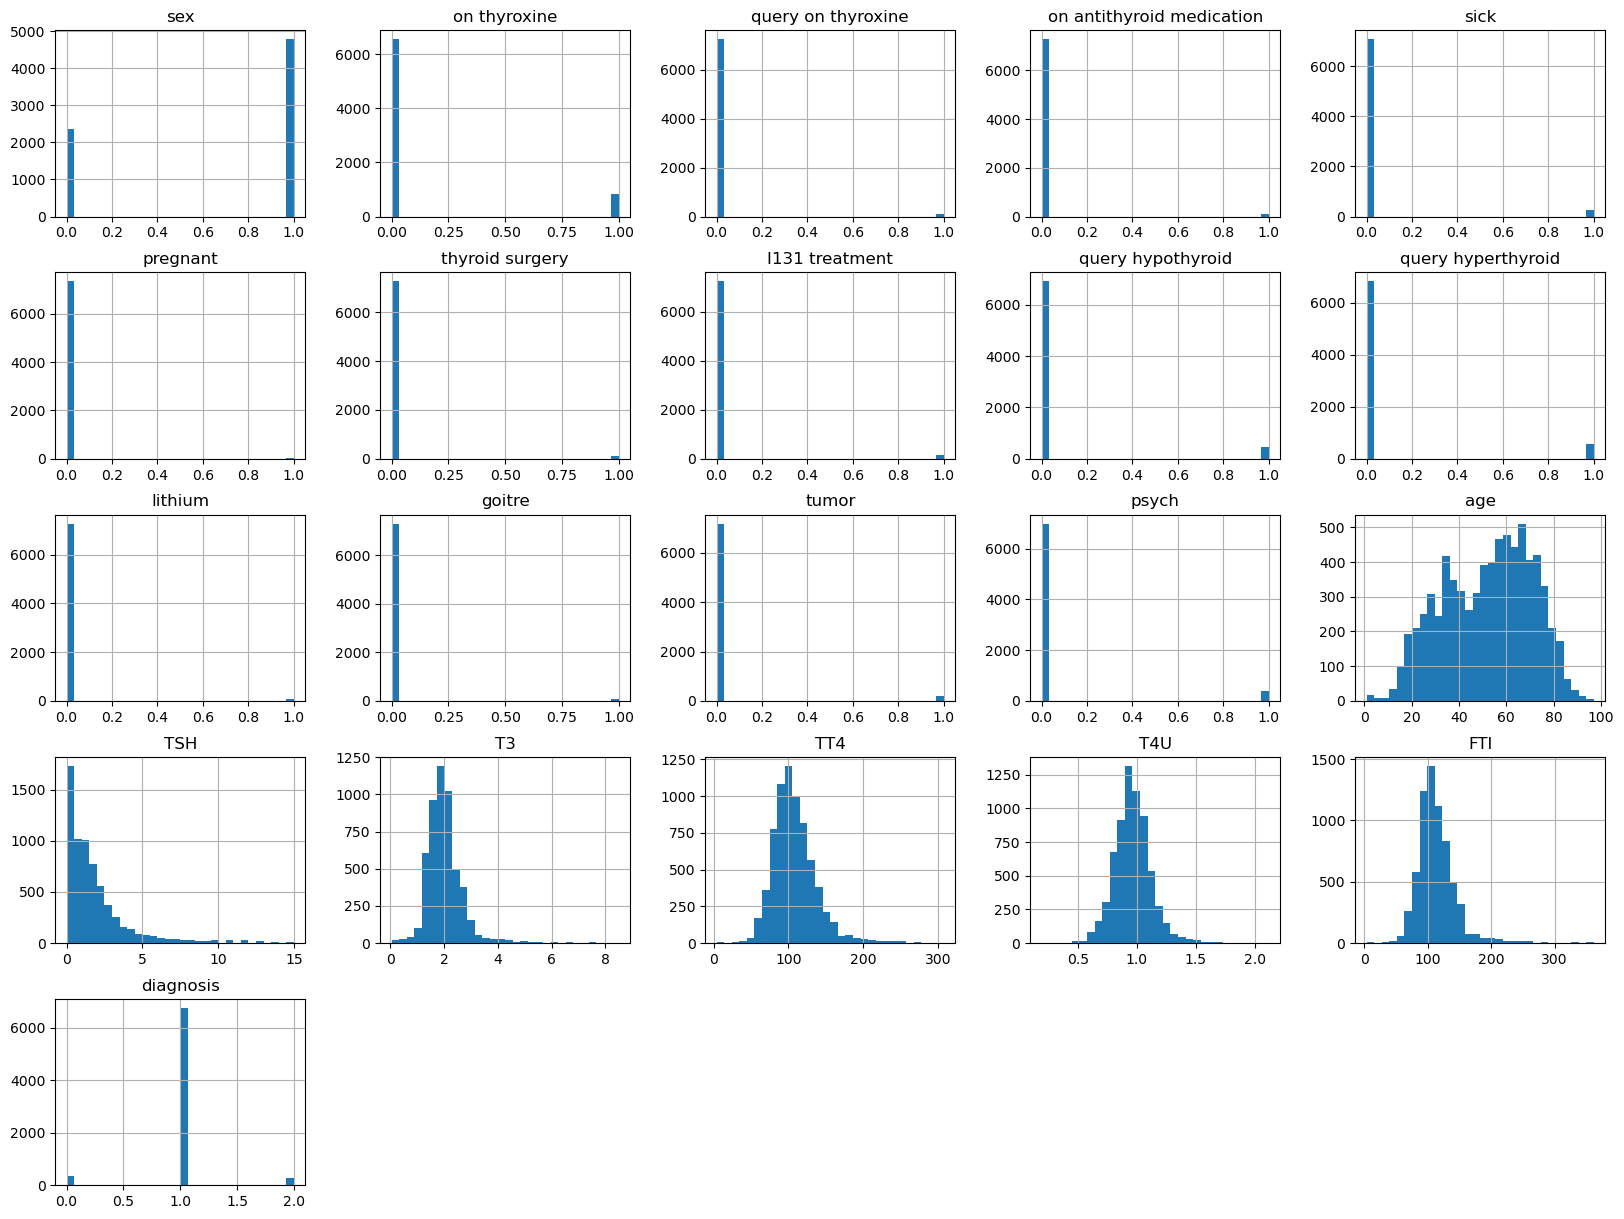

In [184]:
df.hist(bins=30, figsize=(20, 15))

plt.show() 

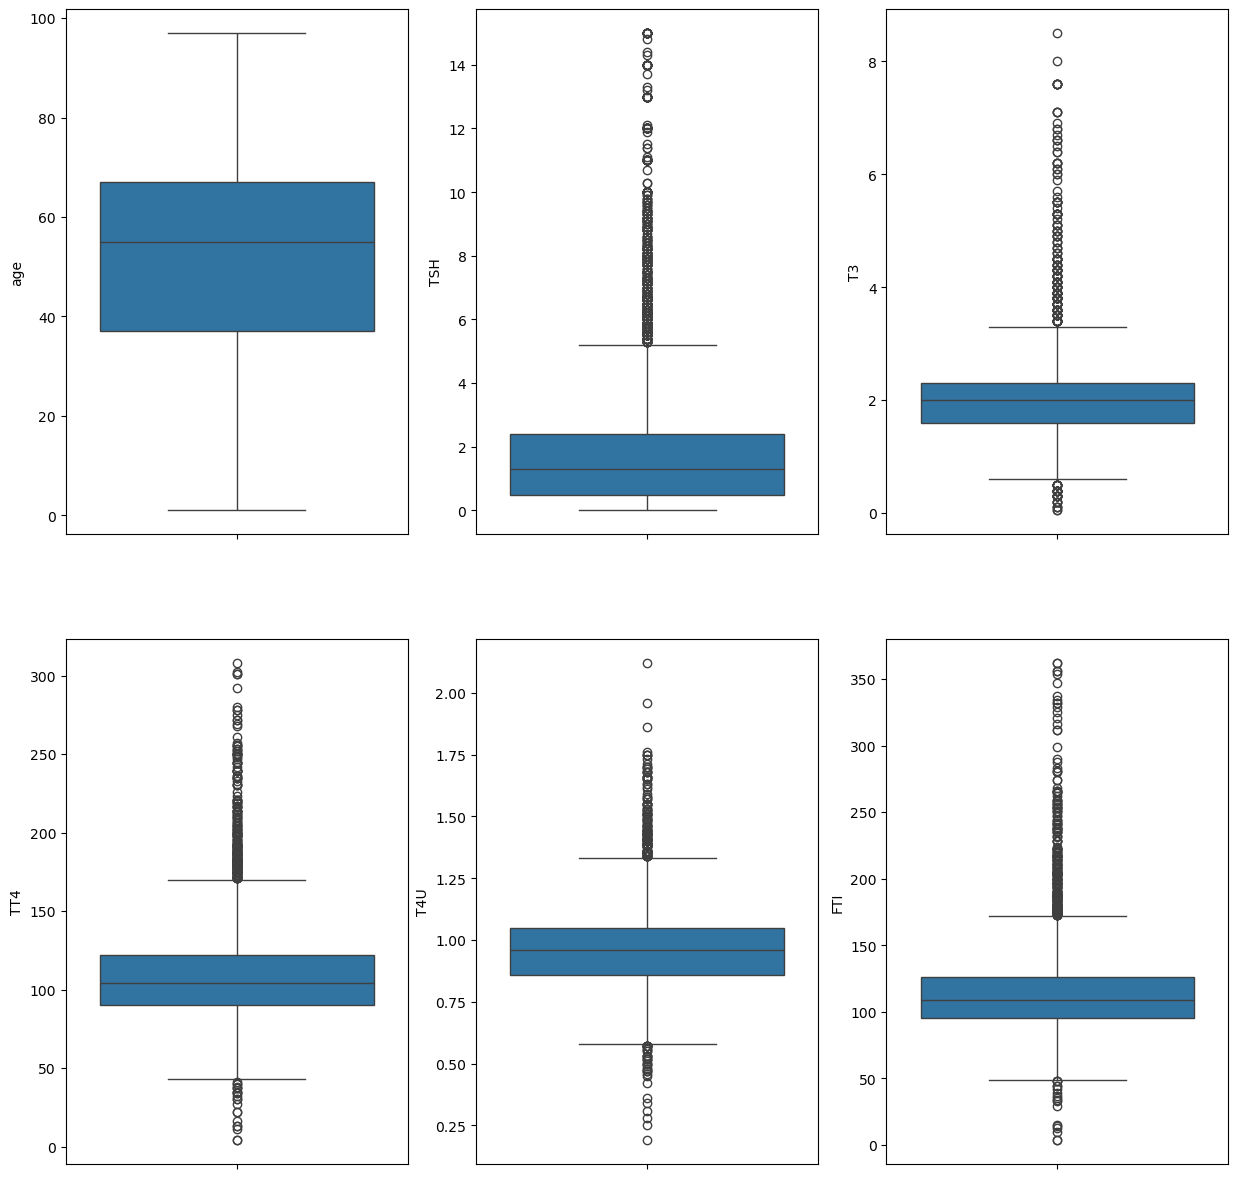

In [134]:

cols = int(np.ceil(np.sqrt(len(numeric_cols))))
f, axes = plt.subplots(nrows=len(numeric_cols) // cols, ncols=cols, figsize=(15, 15))
 
count = 0
for col in numeric_cols:
    sns.boxplot(df[col], ax=axes[count // cols, count % cols])
    count+=1
    
plt.show()

In [156]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(y.value_counts())

1    6748
0     350
2     271
Name: diagnosis, dtype: int64


In [162]:


preproc = Pipeline(steps=[
    ('scaler', ColumnTransformer(transformers=[
        ('scaler', StandardScaler(), numeric_cols),
        ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")),
    ('imputer', IterativeImputer(KNeighborsRegressor(n_neighbors=5), initial_strategy='median', add_indicator=True))
]).set_output(transform='pandas')



In [163]:
X = preproc.fit_transform(X)
X

,age,TSH,T3,TT4,T4U,FTI,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,psych,missingindicator_TSH,missingindicator_T3,missingindicator_TT4,missingindicator_T4U,missingindicator_FTI,missingindicator_sex
0,-1.231140,-0.738661,-0.009191,-0.200119,0.447441,-0.366163,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1,-1.231140,-0.150259,-0.193182,0.669702,1.001449,0.019421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.587557,-0.312296,0.082805,-0.037028,-0.029263,-0.067003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,-0.855716,-0.177416,-0.346507,-0.009846,-0.183870,0.006125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.431450,-0.195521,-0.407838,0.003745,-0.312709,0.192269,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,-0.802084,-0.807459,3.486635,2.674368,-0.029263,2.678625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11938,-1.713827,-0.867657,4.253264,-2.931902,-0.493083,-1.223756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
11941,-0.587557,-0.783923,2.720007,4.916877,1.774483,3.011025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11942,-1.123876,-0.855889,0.941429,2.980165,-0.158102,3.177225,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [242]:
def cross_val_verbose(clf, X, y, iters=16):
    
    side = int(np.ceil(np.sqrt(iters)))
    f, axes = plt.subplots(nrows=side, ncols=side, figsize=(22, 22))
    
    sum_train = 0
    sum_test = 0
    sum_bal = 0
     
    for count in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        clf.fit(X_train, y_train)
        
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        # Calculate accuracy score
        
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_pred_test, y_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred_test)
                                   
        print(f'Train: {train_acc} Test: {test_acc}')
        print(f'Balanced accuracy: {bal_acc}\n')
        
        sum_train += train_acc
        sum_test += test_acc
        sum_bal += bal_acc

        # Show confustion matrix
        conf_mat = confusion_matrix(y_test, y_pred_test)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                       display_labels=classes)
        disp.plot(ax=axes[count // side, count % side])
    
    print(f'Train average: {sum_train / iters} Test average: {sum_test / iters}')
    print(f'Balanced accuracy average: {sum_bal / iters}\n')
    
    plt.show()

In [257]:

scoring = {'accuracy': make_scorer(accuracy_score),
           'balanced accuracy': make_scorer(balanced_accuracy_score),
           'f1 macro' : make_scorer(f1_score, average='macro'),
           'precision macro' : make_scorer(precision_score, average='macro'),
           'recall macro' : make_scorer(recall_score, average='macro'),
           'sensitivity macro' : make_scorer(sensitivity_score, average='macro'),
           'specificity macro' : make_scorer(specificity_score, average='macro'),
           'precision micro' : make_scorer(precision_score, average='micro'),
           'recall micro' : make_scorer(recall_score, average='micro'),
           'sensitivity micro' : make_scorer(sensitivity_score, average='micro'),
           'specificity micro' : make_scorer(specificity_score, average='micro')
        }


In [258]:
#SMOTE CUSTOM RESAMPLING STRATEGY IF NEEDED

'''
has_nans = [feature for feature in df.columns if df[feature].isna().sum() > 0]

class_ratios = {i : df[df['diagnosis'] == i].shape[0] for i in range(len(classes))}
max_samples = max(class_ratios.values())


desired_quo= {'neg' : 0.8, 'hypo': 0.8, 'hyper': 0.8}

desired_samples = {i: int(desired_quo[classes[i]] * max_samples) for i in range(len(classes))}

print(desired_samples)
'''

"\nhas_nans = [feature for feature in df.columns if df[feature].isna().sum() > 0]\n\nclass_ratios = {i : df[df['diagnosis'] == i].shape[0] for i in range(len(classes))}\nmax_samples = max(class_ratios.values())\n\n\ndesired_quo= {'neg' : 0.8, 'hypo': 0.8, 'hyper': 0.8}\n\ndesired_samples = {i: int(desired_quo[classes[i]] * max_samples) for i in range(len(classes))}\n\nprint(desired_samples)\n"

In [259]:
r'''
 _     _____ _____ _____ _____ _____ _____ _____ 
| |   |  _  |  __ \_   _/  ___|_   _|_   _/  __ \
| |   | | | | |  \/ | | \ `--.  | |   | | | /  \/
| |   | | | | | __  | |  `--. \ | |   | | | |    
| |___\ \_/ / |_\ \_| |_/\__/ / | |  _| |_| \__/\
\_____/\___/ \____/\___/\____/  \_/  \___/ \____/
                                                 

                                                 '''

'\n _     _____ _____ _____ _____ _____ _____ _____ \n| |   |  _  |  __ \\_   _/  ___|_   _|_   _/  __ \\\n| |   | | | | |  \\/ | | \\ `--.  | |   | | | /  \\/\n| |   | | | | | __  | |  `--. \\ | |   | | | |    \n| |___\\ \\_/ / |_\\ \\_| |_/\\__/ / | |  _| |_| \\__/\\\n\\_____/\\___/ \\____/\\___/\\____/  \\_/  \\___/ \\____/\n                                                 \n\n                                                 '

In [260]:
logistic = LogisticRegression(max_iter=1000)

clf = Pipeline(steps=[
    ('oversampling', SMOTE(sampling_strategy='all', k_neighbors=4)),
    ('clf', logistic)
]).set_output(transform='pandas')

In [261]:
skf = StratifiedKFold(n_splits=30, shuffle=True)

scores = cross_validate(clf, X, y, cv=skf, scoring=scoring)

# Print the cross-validation scores
print("Cross-validation mean scores: ")
for k, v in scores.items():
    print(f'{k}: {v.mean():.3f}')


Cross-validation mean scores: 
fit_time: 0.379
score_time: 0.014
test_accuracy: 0.959
test_balanced accuracy: 0.969
test_f1 macro: 0.861
test_precision macro: 0.794
test_recall macro: 0.969
test_sensitivity macro: 0.969
test_specificity macro: 0.980
test_precision micro: 0.959
test_recall micro: 0.959
test_sensitivity micro: 0.959
test_specificity micro: 0.980


Train: 0.9610977080820265 Test: 0.9728629579375848
Balanced accuracy: 0.9664197530864197

Train: 0.9610977080820265 Test: 0.9606512890094979
Balanced accuracy: 0.985679012345679

Train: 0.9613992762364294 Test: 0.9620081411126187
Balanced accuracy: 0.974320987654321

Train: 0.9615500603136309 Test: 0.9633649932157394
Balanced accuracy: 0.965784832451499

Train: 0.9642641737032569 Test: 0.9430122116689281
Balanced accuracy: 0.9674074074074074

Train: 0.961248492159228 Test: 0.9674355495251018
Balanced accuracy: 0.9407407407407407

Train: 0.9633594692400482 Test: 0.9565807327001357
Balanced accuracy: 0.948641975308642

Train: 0.9595898673100121 Test: 0.9579375848032564
Balanced accuracy: 0.9846913580246914

Train: 0.9613992762364294 Test: 0.9633649932157394
Balanced accuracy: 0.9748148148148147

Train: 0.9630579010856454 Test: 0.9538670284938942
Balanced accuracy: 0.9713580246913579

Train: 0.9615500603136309 Test: 0.9552238805970149
Balanced accuracy: 0.96

Train: 0.9623039806996381 Tes

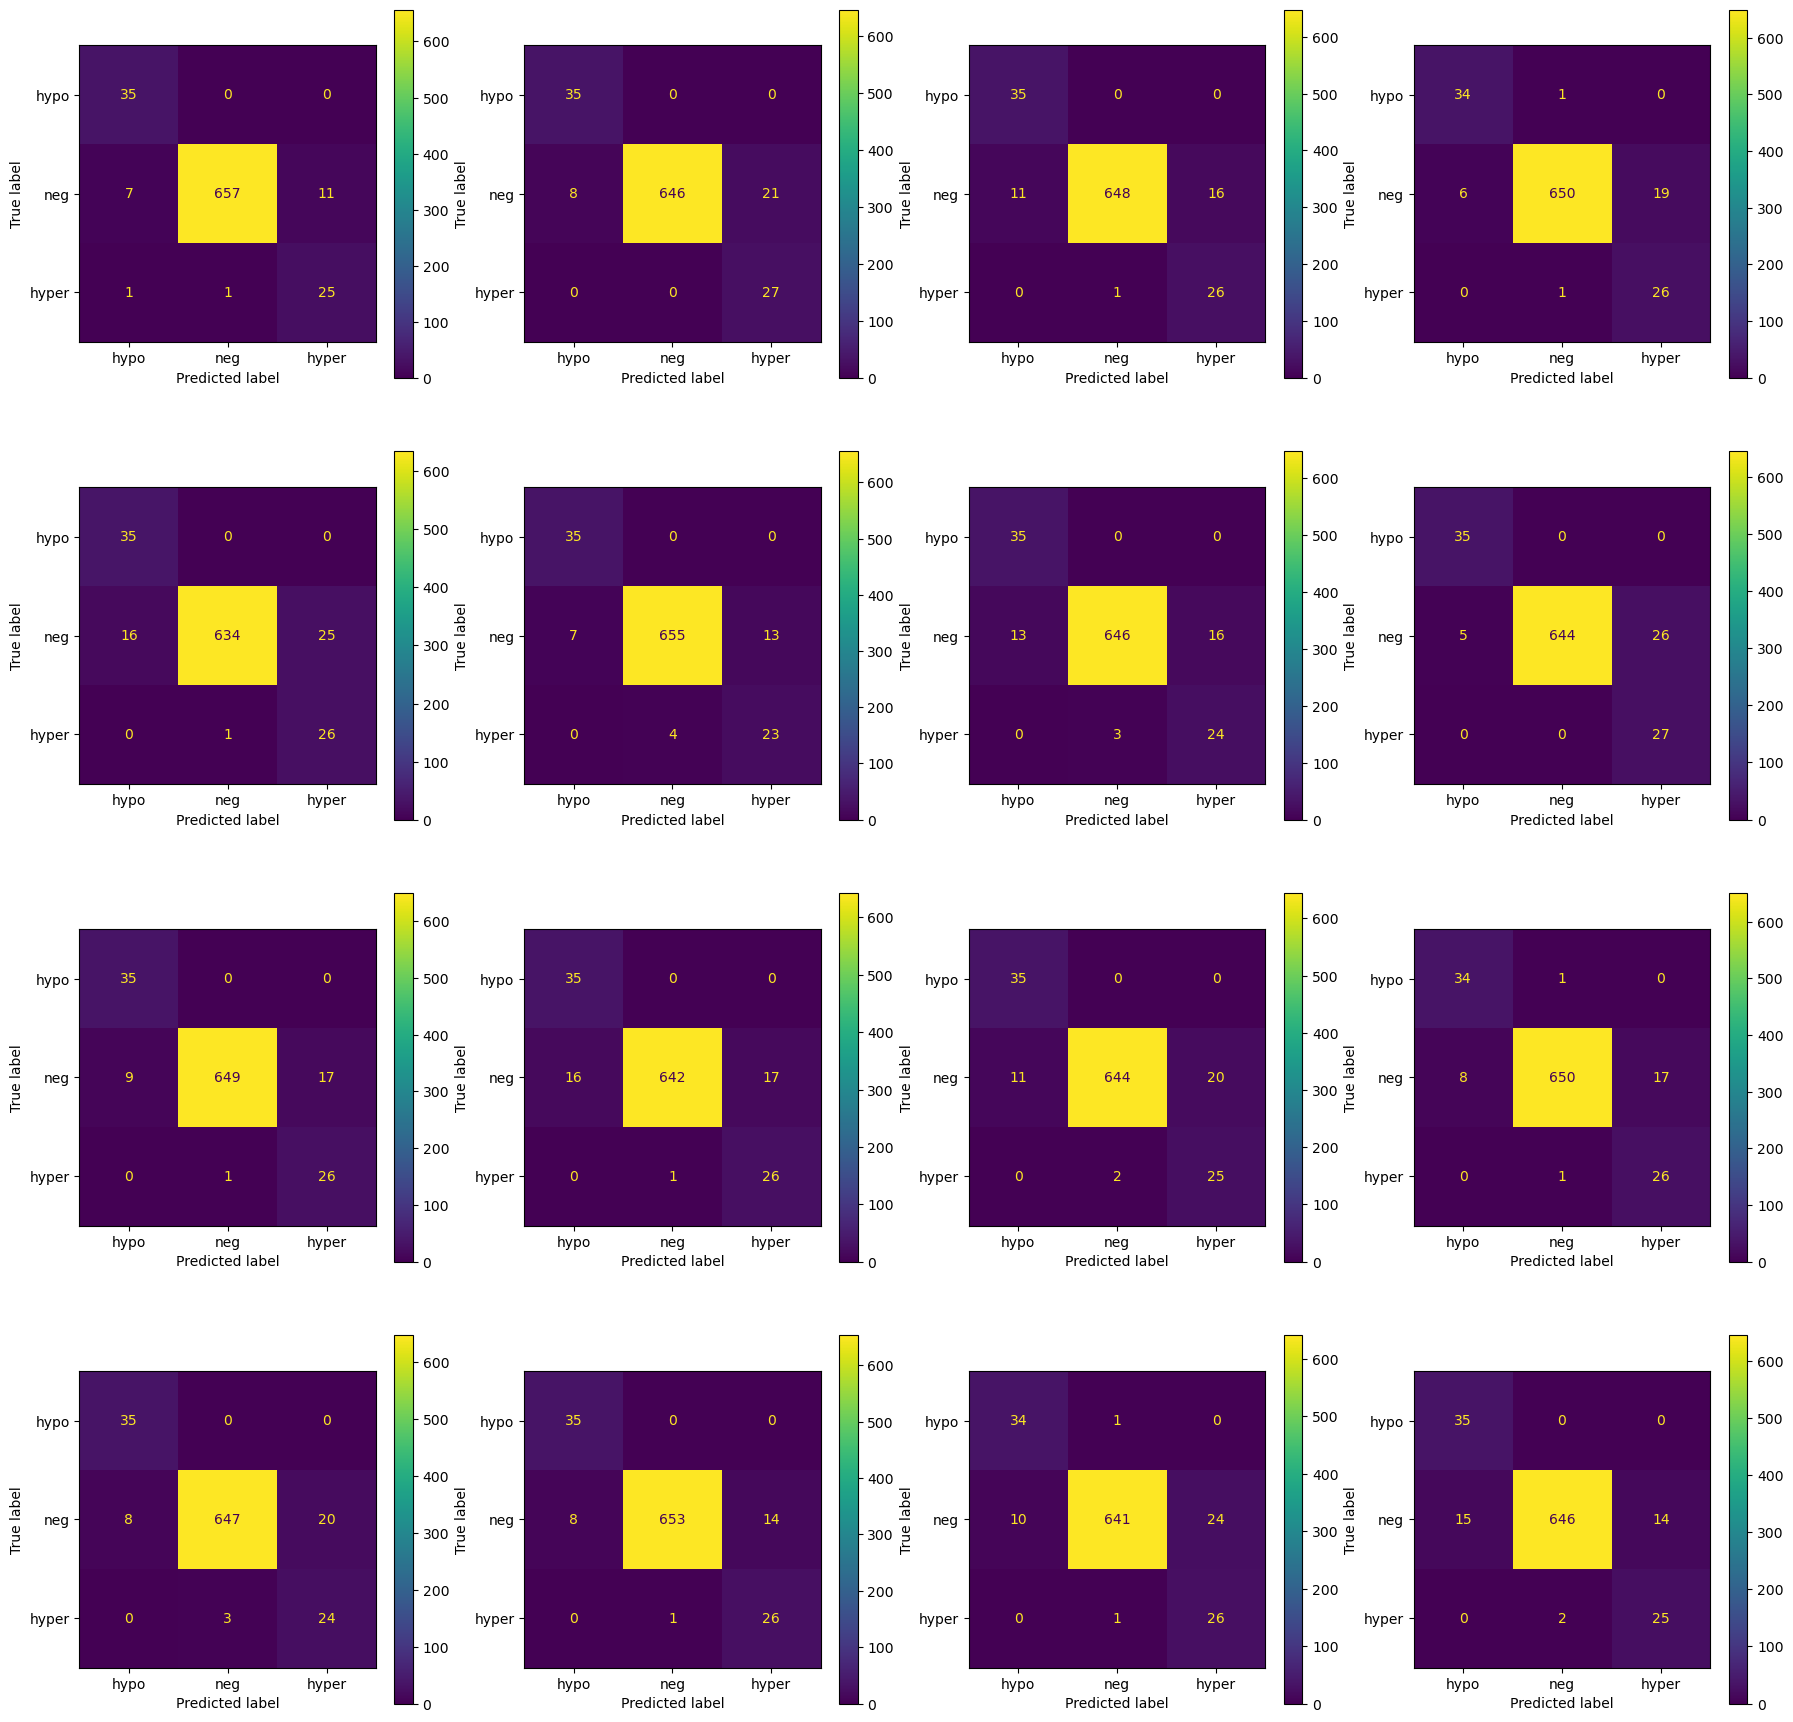

In [271]:
cross_val_verbose(clf, X, y)

In [263]:
r'''
  ___      _      ______                 _   
 / _ \    | |     | ___ \               | |  
/ /_\ \ __| | __ _| |_/ / ___   ___  ___| |_ 
|  _  |/ _` |/ _` | ___ \/ _ \ / _ \/ __| __|
| | | | (_| | (_| | |_/ / (_) | (_) \__ \ |_ 
\_| |_/\__,_|\__,_\____/ \___/ \___/|___/\__|
                                             
                                             '''

'\n  ___      _      ______                 _   \n / _ \\    | |     | ___ \\               | |  \n/ /_\\ \\ __| | __ _| |_/ / ___   ___  ___| |_ \n|  _  |/ _` |/ _` | ___ \\/ _ \\ / _ \\/ __| __|\n| | | | (_| | (_| | |_/ / (_) | (_) \\__ \\ |_ \n\\_| |_/\\__,_|\\__,_\\____/ \\___/ \\___/|___/\\__|\n                                             \n                                             '

In [264]:


abc_clf = Pipeline(steps=[
    ('oversampling', SMOTE(sampling_strategy='auto', k_neighbors=3)),
    ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), 
                         algorithm='SAMME',
                         n_estimators=100,
                         learning_rate=0.5))
]).set_output(transform='pandas') 


In [265]:
skf = StratifiedKFold(n_splits=30, shuffle=True)

scores = cross_validate(abc_clf, X, y, cv=skf, scoring=scoring)
 
# Print the cross-validation scores
print("Cross-validation mean scores: ")
for k, v in scores.items():
    print(f'{k}: {v.mean():.3f}')


Cross-validation mean scores: 
fit_time: 4.255
score_time: 0.017
test_accuracy: 0.986
test_balanced accuracy: 0.969
test_f1 macro: 0.944
test_precision macro: 0.926
test_recall macro: 0.969
test_sensitivity macro: 0.969
test_specificity macro: 0.984
test_precision micro: 0.986
test_recall micro: 0.986
test_sensitivity micro: 0.986
test_specificity micro: 0.993


Train: 0.9996984318455971 Test: 0.9905020352781547
Balanced accuracy: 0.9519576719576719

Train: 0.9984921592279855 Test: 0.9769335142469471
Balanced accuracy: 0.9560493827160493

Train: 0.996984318455971 Test: 0.9877883310719131
Balanced accuracy: 0.9955555555555556

Train: 0.9987937273823885 Test: 0.9850746268656716
Balanced accuracy: 0.9827160493827161

Train: 0.9989445114595898 Test: 0.9864314789687924
Balanced accuracy: 0.9623280423280424

Train: 0.9981905910735827 Test: 0.9905020352781547
Balanced accuracy: 0.9756613756613756

Train: 0.9990952955367913 Test: 0.9864314789687924
Balanced accuracy: 0.9713580246913581

Train: 0.9993968636911942 Test: 0.989145183175034
Balanced accuracy: 0.948641975308642

Train: 0.9989445114595898 Test: 0.989145183175034
Balanced accuracy: 0.9841975308641975

Train: 0.9990952955367913 Test: 0.9877883310719131
Balanced accuracy: 0.96

Train: 0.9992460796139928 Test: 0.9850746268656716
Balanced accuracy: 0.9827160493827161

Train: 0.9987937273823885 Te

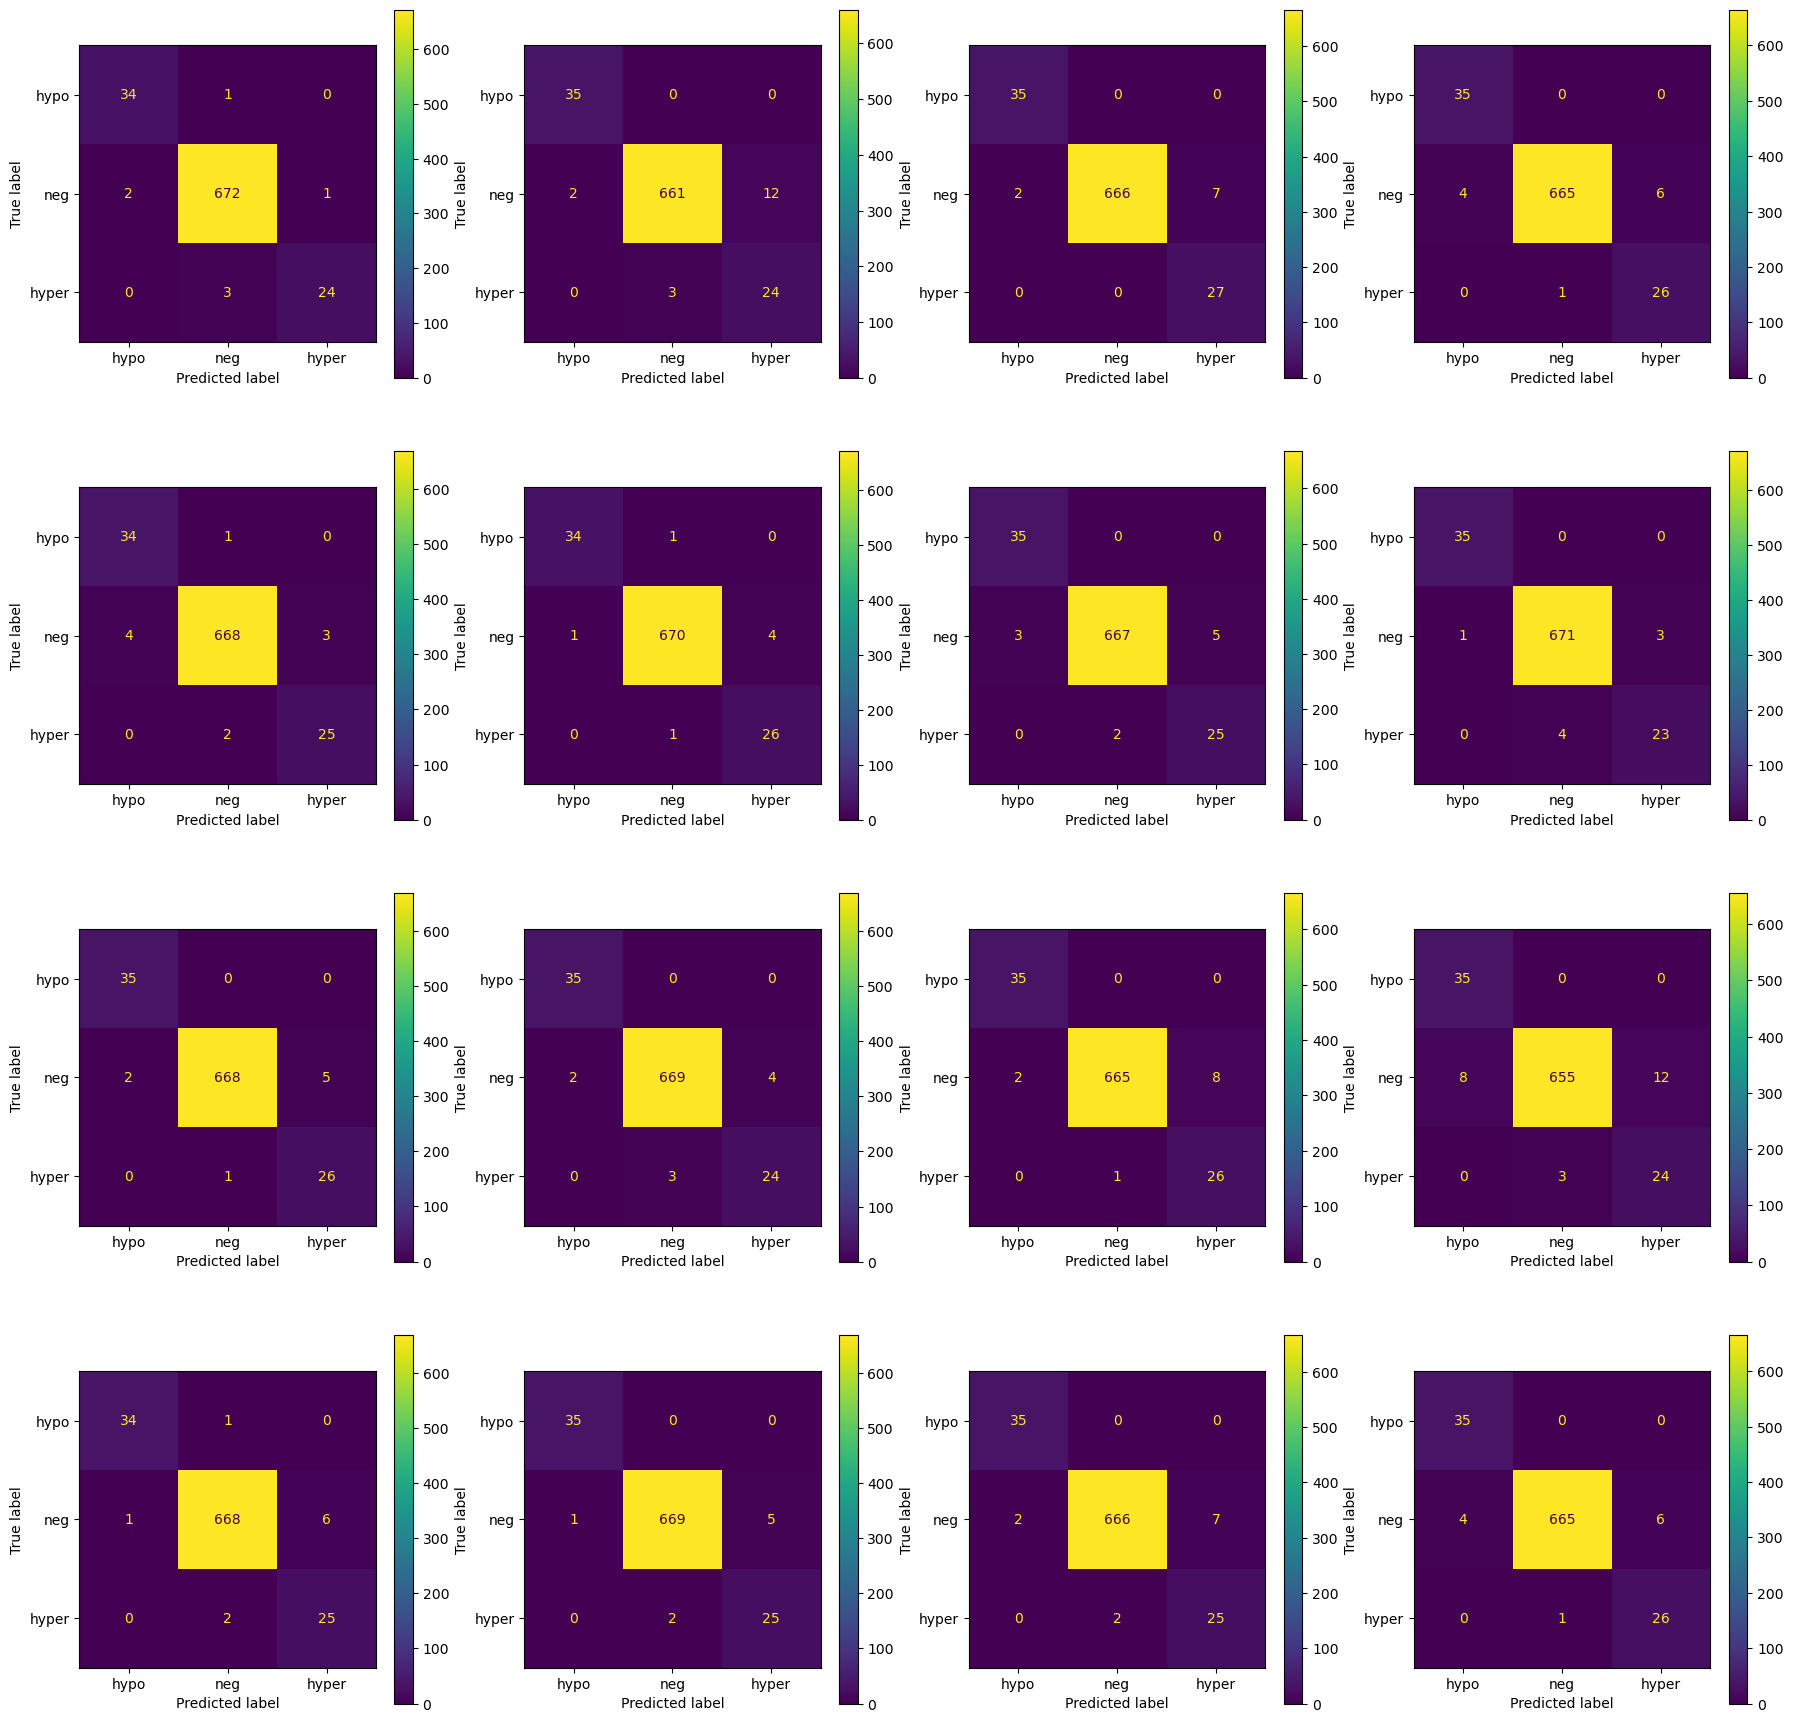

In [272]:
cross_val_verbose(abc_clf, X, y, iters=16)

In [267]:
r'''
______                _                  ______                  _   
| ___ \              | |                 |  ___|                | |  
| |_/ /__ _ _ __   __| | ___  _ __ ___   | |_ ___  _ __ ___  ___| |_ 
|    // _` | '_ \ / _` |/ _ \| '_ ` _ \  |  _/ _ \| '__/ _ \/ __| __|
| |\ \ (_| | | | | (_| | (_) | | | | | | | || (_) | | |  __/\__ \ |_ 
\_| \_\__,_|_| |_|\__,_|\___/|_| |_| |_| \_| \___/|_|  \___||___/\__|
                                                                     

                                                                     '''

"\n______                _                  ______                  _   \n| ___ \\              | |                 |  ___|                | |  \n| |_/ /__ _ _ __   __| | ___  _ __ ___   | |_ ___  _ __ ___  ___| |_ \n|    // _` | '_ \\ / _` |/ _ \\| '_ ` _ \\  |  _/ _ \\| '__/ _ \\/ __| __|\n| |\\ \\ (_| | | | | (_| | (_) | | | | | | | || (_) | | |  __/\\__ \\ |_ \n\\_| \\_\\__,_|_| |_|\\__,_|\\___/|_| |_| |_| \\_| \\___/|_|  \\___||___/\\__|\n                                                                     \n\n                                                                     "

In [268]:

forest_clf = Pipeline(steps=[
    ('oversampling', SMOTE(sampling_strategy='auto', k_neighbors=3)),
    ('clf', RandomForestClassifier(n_estimators=160, max_depth=12, class_weight='balanced'))
]).set_output(transform='pandas') 



In [269]:

scores = cross_validate(forest_clf, X, y, cv=skf, scoring=scoring)
 
# Print the cross-validation scores
print("Cross-validation mean scores: ")
for k, v in scores.items():
    print(f'{k}: {v.mean():.3f}')



Cross-validation mean scores: 
fit_time: 2.907
score_time: 0.015
test_accuracy: 0.990
test_balanced accuracy: 0.970
test_f1 macro: 0.956
test_precision macro: 0.947
test_recall macro: 0.970
test_sensitivity macro: 0.970
test_specificity macro: 0.985
test_precision micro: 0.990
test_recall micro: 0.990
test_sensitivity micro: 0.990
test_specificity micro: 0.995


Train: 0.9975874547647768 Test: 0.9877883310719131
Balanced accuracy: 0.9362962962962963

Train: 0.997285886610374 Test: 0.9918588873812755
Balanced accuracy: 0.9614814814814814

Train: 0.997285886610374 Test: 0.9959294436906377
Balanced accuracy: 0.9866666666666667

Train: 0.9980398069963812 Test: 0.9823609226594301
Balanced accuracy: 0.9580246913580247

Train: 0.9977382388419783 Test: 0.9837177747625508
Balanced accuracy: 0.9822222222222222

Train: 0.9975874547647768 Test: 0.9918588873812755
Balanced accuracy: 0.9524514991181657

Train: 0.9974366706875754 Test: 0.9850746268656716
Balanced accuracy: 0.9590123456790124

Train: 0.9975874547647768 Test: 0.989145183175034
Balanced accuracy: 0.96331569664903

Train: 0.9975874547647768 Test: 0.9864314789687924
Balanced accuracy: 0.9595061728395061

Train: 0.996984318455971 Test: 0.9959294436906377
Balanced accuracy: 0.9866666666666667

Train: 0.9974366706875754 Test: 0.9877883310719131
Balanced accuracy: 0.9837037037037036

Train: 0.9975874

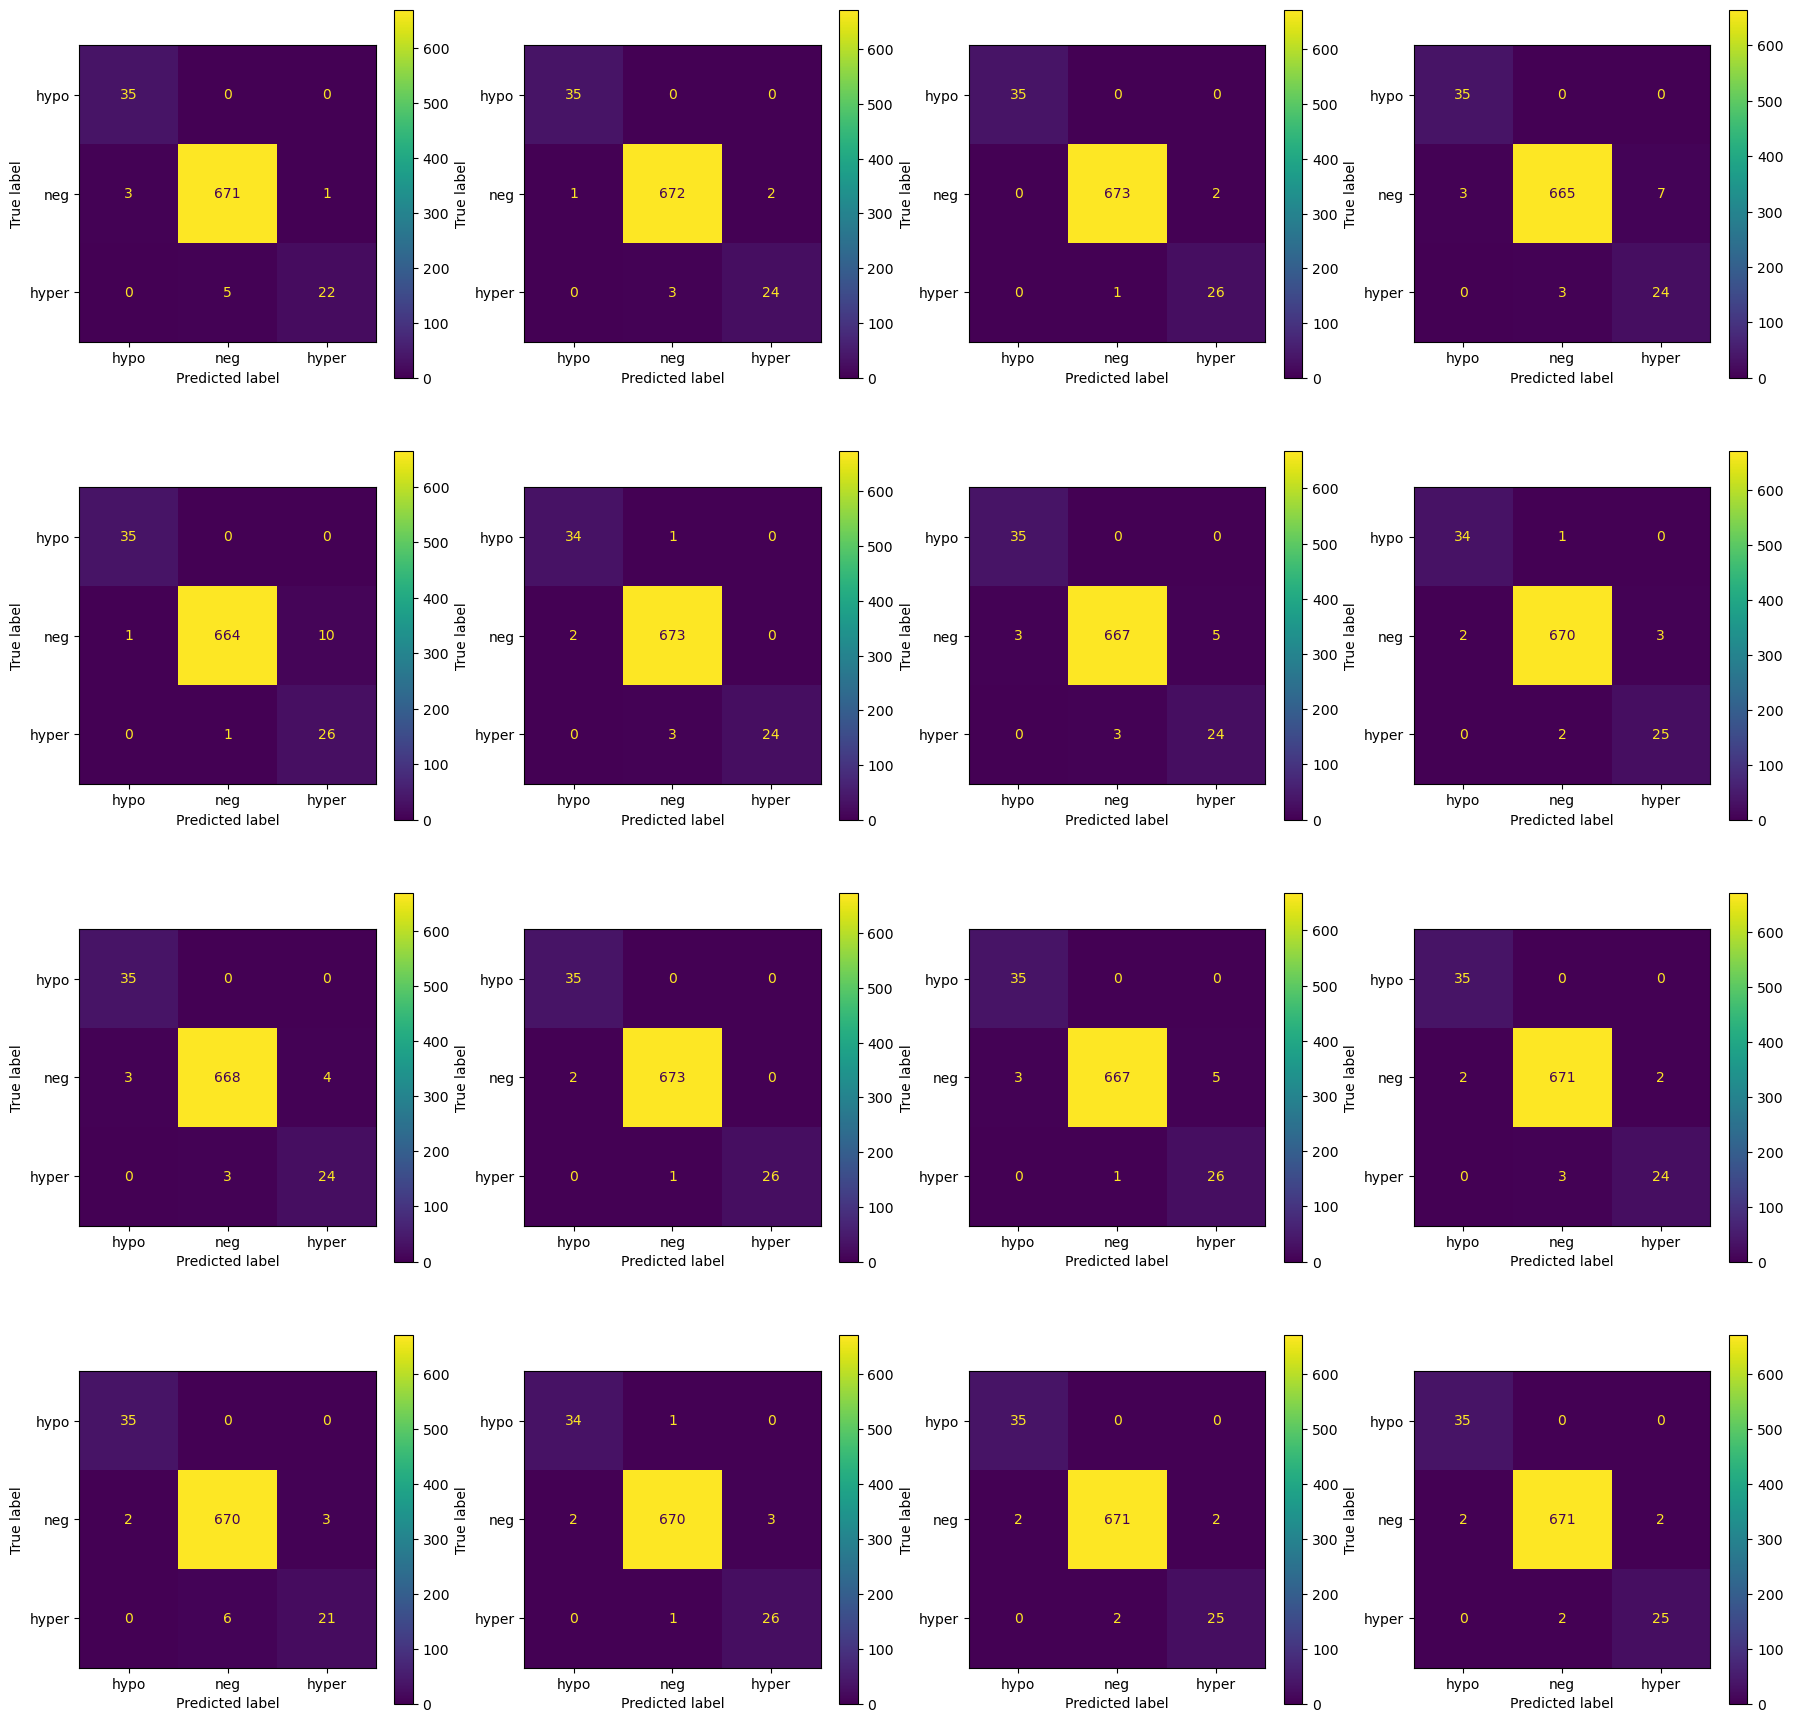

In [273]:
cross_val_verbose(forest_clf, X, y, iters=16)